# Next Word Prediction:

### Importing The Required Libraries:

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import pickle
import numpy as np
import os

In [2]:
# Remove all unneccesary data or text 
file = open("metamorphosis_clean.txt", "r", encoding = "utf8")
lines = []

for i in file:
    lines.append(i)
    
print("The First Line: ", lines[0])
print("The Last Line: ", lines[-1])

The First Line:  ﻿One morning, when Gregor Samsa woke from troubled dreams, he found

The Last Line:  first to get up and stretch out her young body.


### Cleaning the data:

In [3]:
data = ""

for i in lines:
    data = ' '. join(lines)
    
data = data.replace('\n', '').replace('\r', '').replace('\ufeff', '')
data[:360]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin.  He lay on his armour-like back, and if he lifted his head a little he could see his brown belly, slightly domed and divided by arches into stiff sections.  The bedding was hardly able to cover it and seemed ready to slide off any moment.'

In [4]:
import string

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation)) #map punctuation to space
new_data = data.translate(translator)

new_data[:500]

'One morning  when Gregor Samsa woke from troubled dreams  he found himself transformed in his bed into a horrible vermin   He lay on his armour like back  and if he lifted his head a little he could see his brown belly  slightly domed and divided by arches into stiff sections   The bedding was hardly able to cover it and seemed ready to slide off any moment   His many legs  pitifully thin compared with the size of the rest of him  waved about helplessly as he looked    What s happened to me   he'

In [5]:
z = []

for i in data.split():
    if i not in z:
        z.append(i)
        
data = ' '.join(z)
data[:500]

'One morning, when Gregor Samsa woke from troubled dreams, he found himself transformed in his bed into a horrible vermin. He lay on armour-like back, and if lifted head little could see brown belly, slightly domed divided by arches stiff sections. The bedding was hardly able to cover it seemed ready slide off any moment. His many legs, pitifully thin compared with the size of rest him, waved about helplessly as looked. "What\'s happened me?" thought. It wasn\'t dream. room, proper human room altho'

### Tokenization:

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# saving the tokenizer for predict function.
pickle.dump(tokenizer, open('tokenizer1.pkl', 'wb'))

sequence_data = tokenizer.texts_to_sequences([data])[0]
sequence_data[:10]

[17, 53, 293, 2, 18, 729, 135, 730, 294, 8]

In [7]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

2617


In [8]:
sequences = []

for i in range(1, len(sequence_data)):
    words = sequence_data[i-1:i+1]
    sequences.append(words)
    
print("The Length of sequences are: ", len(sequences))
sequences = np.array(sequences)
sequences[:10]

The Length of sequences are:  3889


array([[ 17,  53],
       [ 53, 293],
       [293,   2],
       [  2,  18],
       [ 18, 729],
       [729, 135],
       [135, 730],
       [730, 294],
       [294,   8],
       [  8, 731]])

In [9]:
X = []
y = []

for i in sequences:
    X.append(i[0])
    y.append(i[1])
    
X = np.array(X)
y = np.array(y)

In [10]:
print("The Data is: ", X[:5])
print("The responses are: ", y[:5])

The Data is:  [ 17  53 293   2  18]
The responses are:  [ 53 293   2  18 729]


In [11]:
y = to_categorical(y, num_classes=vocab_size)
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Creating the Model:

In [12]:
model = Sequential()
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(1000, return_sequences=True))
model.add(LSTM(1000))
model.add(Dense(1000, activation="relu"))
model.add(Dense(vocab_size, activation="softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 10)             26170     
_________________________________________________________________
lstm (LSTM)                  (None, 1, 1000)           4044000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 1000)              8004000   
_________________________________________________________________
dense (Dense)                (None, 1000)              1001000   
_________________________________________________________________
dense_1 (Dense)              (None, 2617)              2619617   
Total params: 15,694,787
Trainable params: 15,694,787
Non-trainable params: 0
_________________________________________________________________


### Plot The Model:

Using TensorFlow backend.


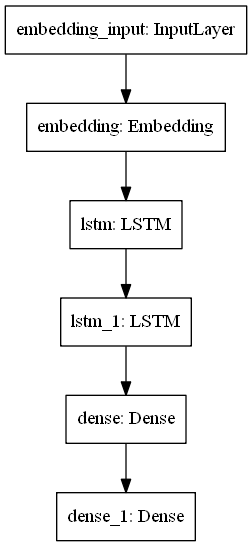

In [14]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model, to_file='model.png', show_layer_names=True)

### Callbacks:

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard

checkpoint = ModelCheckpoint("nextword1.h5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

reduce = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.0001, verbose = 1)

logdir='logsnextword1'
tensorboard_Visualization = TensorBoard(log_dir=logdir)

### Compile The Model:

In [16]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001))

### Fit The Model:

In [17]:
model.fit(X, y, epochs=150, batch_size=64, callbacks=[checkpoint, reduce, tensorboard_Visualization])

Train on 3889 samples
Epoch 1/150
3712/3889 [===========================>..] - ETA: 0s - loss: 7.8752
Epoch 00001: loss improved from inf to 7.87560, saving model to nextword1.h5
3889/3889 [==============================] - 5s 1ms/sample - loss: 7.8756
Epoch 2/150
3648/3889 [===========================>..] - ETA: 0s - loss: 7.8587
Epoch 00002: loss improved from 7.87560 to 7.86009, saving model to nextword1.h5
3889/3889 [==============================] - 1s 331us/sample - loss: 7.8601
Epoch 3/150
3648/3889 [===========================>..] - ETA: 0s - loss: 7.8187
Epoch 00003: loss improved from 7.86009 to 7.81623, saving model to nextword1.h5
3889/3889 [==============================] - 1s 372us/sample - loss: 7.8162
Epoch 4/150
3648/3889 [===========================>..] - ETA: 0s - loss: 7.6399
Epoch 00004: loss improved from 7.81623 to 7.63961, saving model to nextword1.h5
3889/3889 [==============================] - 1s 327us/sample - loss: 7.6396
Epoch 5/150
3648/3889 [=============

3889/3889 [==============================] - 1s 370us/sample - loss: 1.3715
Epoch 70/150
3648/3889 [===========================>..] - ETA: 0s - loss: 1.3227
Epoch 00070: loss improved from 1.37151 to 1.33558, saving model to nextword1.h5
3889/3889 [==============================] - 1s 358us/sample - loss: 1.3356
Epoch 71/150
3648/3889 [===========================>..] - ETA: 0s - loss: 1.2890
Epoch 00071: loss improved from 1.33558 to 1.31252, saving model to nextword1.h5
3889/3889 [==============================] - 1s 319us/sample - loss: 1.3125
Epoch 72/150
3648/3889 [===========================>..] - ETA: 0s - loss: 1.2673
Epoch 00072: loss improved from 1.31252 to 1.28071, saving model to nextword1.h5
3889/3889 [==============================] - 1s 358us/sample - loss: 1.2807
Epoch 73/150
3648/3889 [===========================>..] - ETA: 0s - loss: 1.2503
Epoch 00073: loss improved from 1.28071 to 1.26773, saving model to nextword1.h5
3889/3889 [==============================] - 2s 

Epoch 105/150
3648/3889 [===========================>..] - ETA: 0s - loss: 0.6752- ETA: 0s - los
Epoch 00105: loss improved from 0.68539 to 0.68348, saving model to nextword1.h5
3889/3889 [==============================] - 2s 411us/sample - loss: 0.6835
Epoch 106/150
3648/3889 [===========================>..] - ETA: 0s - loss: 0.6793
Epoch 00106: loss improved from 0.68348 to 0.68141, saving model to nextword1.h5
3889/3889 [==============================] - 1s 381us/sample - loss: 0.6814
Epoch 107/150
3648/3889 [===========================>..] - ETA: 0s - loss: 0.6729
Epoch 00107: loss improved from 0.68141 to 0.67983, saving model to nextword1.h5
3889/3889 [==============================] - 2s 413us/sample - loss: 0.6798
Epoch 108/150
3648/3889 [===========================>..] - ETA: 0s - loss: 0.6734
Epoch 00108: loss did not improve from 0.67983
3889/3889 [==============================] - 1s 297us/sample - loss: 0.6801
Epoch 109/150
3648/3889 [===========================>..] - ETA:

Epoch 142/150
3776/3889 [============================>.] - ETA: 0s - loss: 0.6279
Epoch 00142: loss did not improve from 0.62663
3889/3889 [==============================] - 1s 319us/sample - loss: 0.6278
Epoch 143/150
3648/3889 [===========================>..] - ETA: 0s - loss: 0.6270
Epoch 00143: loss did not improve from 0.62663
3889/3889 [==============================] - 1s 249us/sample - loss: 0.6268
Epoch 144/150
3648/3889 [===========================>..] - ETA: 0s - loss: 0.6195
Epoch 00144: loss did not improve from 0.62663
3889/3889 [==============================] - 1s 239us/sample - loss: 0.6276
Epoch 145/150
3648/3889 [===========================>..] - ETA: 0s - loss: 0.6204
Epoch 00145: loss did not improve from 0.62663
3889/3889 [==============================] - 1s 239us/sample - loss: 0.6271
Epoch 146/150
3648/3889 [===========================>..] - ETA: 0s - loss: 0.6203
Epoch 00146: loss did not improve from 0.62663
3889/3889 [==============================] - 1s 239